In [1]:
import itertools
import os

import numpy as np
import pandas as pd
from plotnine import *

In [2]:
fuzzers = ['zest', 'bedivfuzz', 'bedivfuzz-split', 'bedivfuzz-structure']
subjects = ['ant', 'bcel', 'chocopy', 'closure', 'maven', 'nashorn', 'pngj', 'rhino', 'tomcat']
num_trials = 20
timeout = 180

results_base_dir = 'results/eval-bedivfuzz-metrics-178009'

In [3]:
def trial_df(fuzzer: str, subject: str, trial: int):
    df = pd.read_csv(
        os.path.join(results_base_dir, fuzzer, subject, f'trial-{trial}', 'plot_data'),
        skipinitialspace=True
    )

    if fuzzer == 'bedivfuzz-split':
        zest_plot_data = pd.read_csv(
            os.path.join(results_base_dir, fuzzer, subject, f'trial-{trial}', 'zest-results', 'plot_data'),
            skipinitialspace=True
        )

        df = pd.concat([zest_plot_data, df], ignore_index=True)

    # one datapoint per minute
    df = df.loc[np.linspace(0, len(df)-1, timeout, endpoint=True, dtype=np.int64)]
    df['time'] = range(1, timeout+1)
    df['trial'] = trial
    df['fuzzer'] = fuzzer
    df['subject'] = subject
    df['validity_rate'] = df['valid_inputs'] / (df['valid_inputs'] + df['invalid_inputs'])

    return df[[
            'fuzzer', 'subject', 'trial', 'time', 
            'valid_inputs', 'invalid_inputs', 'validity_rate', 'unique_paths', 'unique_valid_paths',
            'num_coverage_probes', 'num_semantic_probes', 'b0', 'b1', 'b2'
        ]]

In [4]:
dfs = []
for f, s, t in itertools.product(fuzzers, subjects, range(1, num_trials+1)):
    dfs.append(trial_df(fuzzer=f, subject=s, trial=t))
trials = pd.concat(dfs)

In [5]:
mean_trials = trials.groupby(['fuzzer', 'subject', 'time']).agg('mean')
mean_trials.head()

trial  valid_inputs  invalid_inputs  validity_rate  \
fuzzer    subject time                                                       
bedivfuzz ant     1      10.5          0.00            1.00       0.000000   
                  2      10.5         14.65        12664.15       0.001346   
                  3      10.5         93.25        27220.55       0.006217   
                  4      10.5        246.80        39152.25       0.012049   
                  5      10.5        423.10        49420.75       0.018347   

                        unique_paths  unique_valid_paths  num_coverage_probes  \
fuzzer    subject time                                                          
bedivfuzz ant     1             1.00                0.00             86785.55   
                  2          6568.40                9.80             93376.70   
                  3         12246.75               63.80            102303.50   
                  4         16628.50              145.15            107316.85   
                  5         19928.80              266.15            110682.50   

                        num_semantic_probes       b0         b1         b2  
fuzzer    subject time                                                      
bedivfuzz ant     1                 8481.00  4341.60  4341.6000  4341.6000  
                  2                20952.00  5134.95  3619.1710  3579.5935  
                  3                39243.50  5534.80  3709.8100  3633.2120  
                  4                49729.20  5726.45  3763.8450  3670.3710  
                  5                56531.35  5840.45  3806.9245  3702.0190

/Users/lam/_projects/bedivfuzz/.venv/lib/python3.11/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



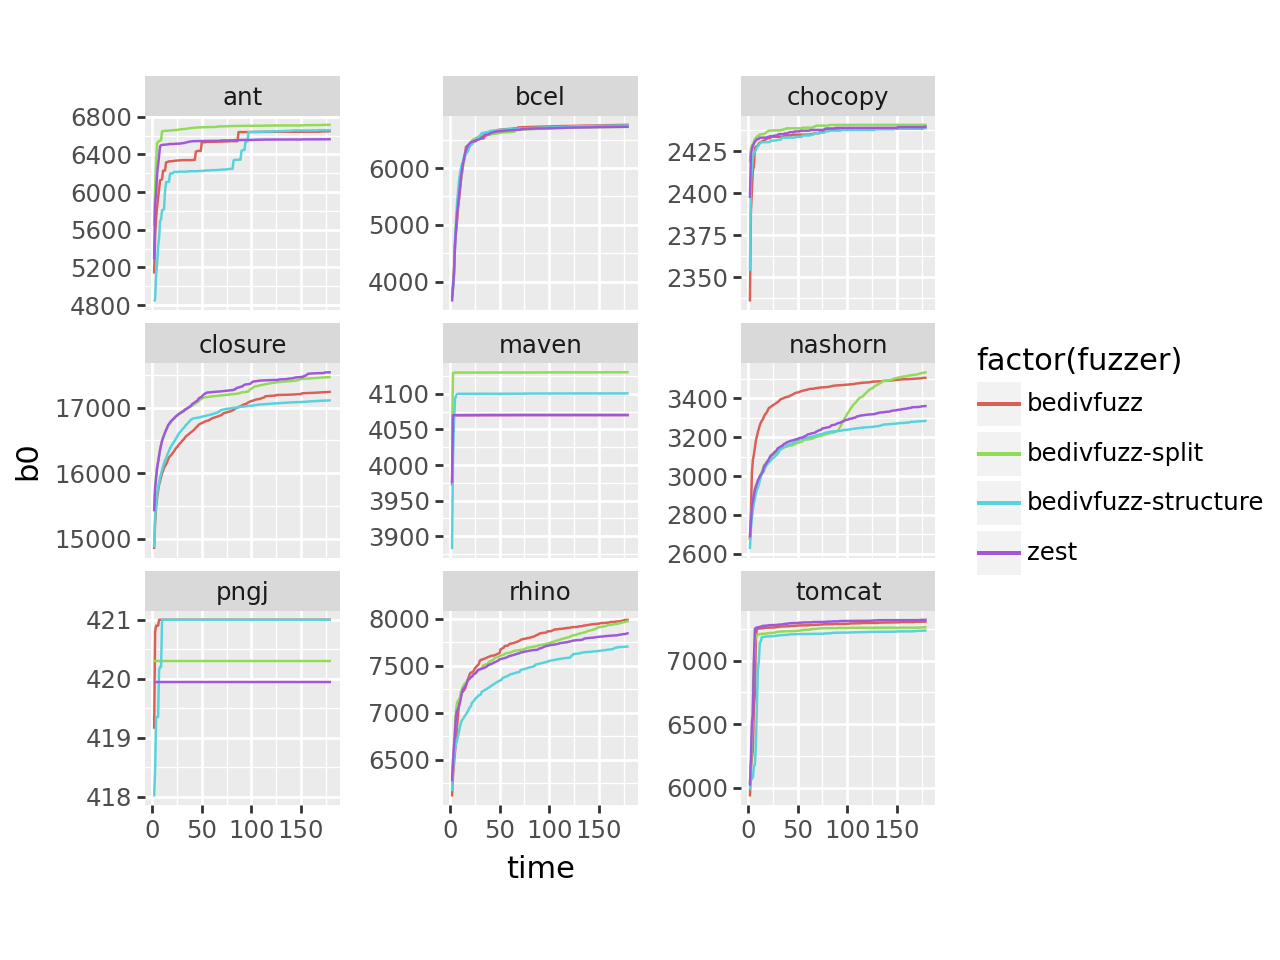

In [14]:
(ggplot(mean_trials.reset_index().query("time > 1"), aes("time", "b0", color="factor(fuzzer)"))
 + geom_line()
 + facet_wrap("~subject", scales="free_y")
 + theme(aspect_ratio = 1.0)
)

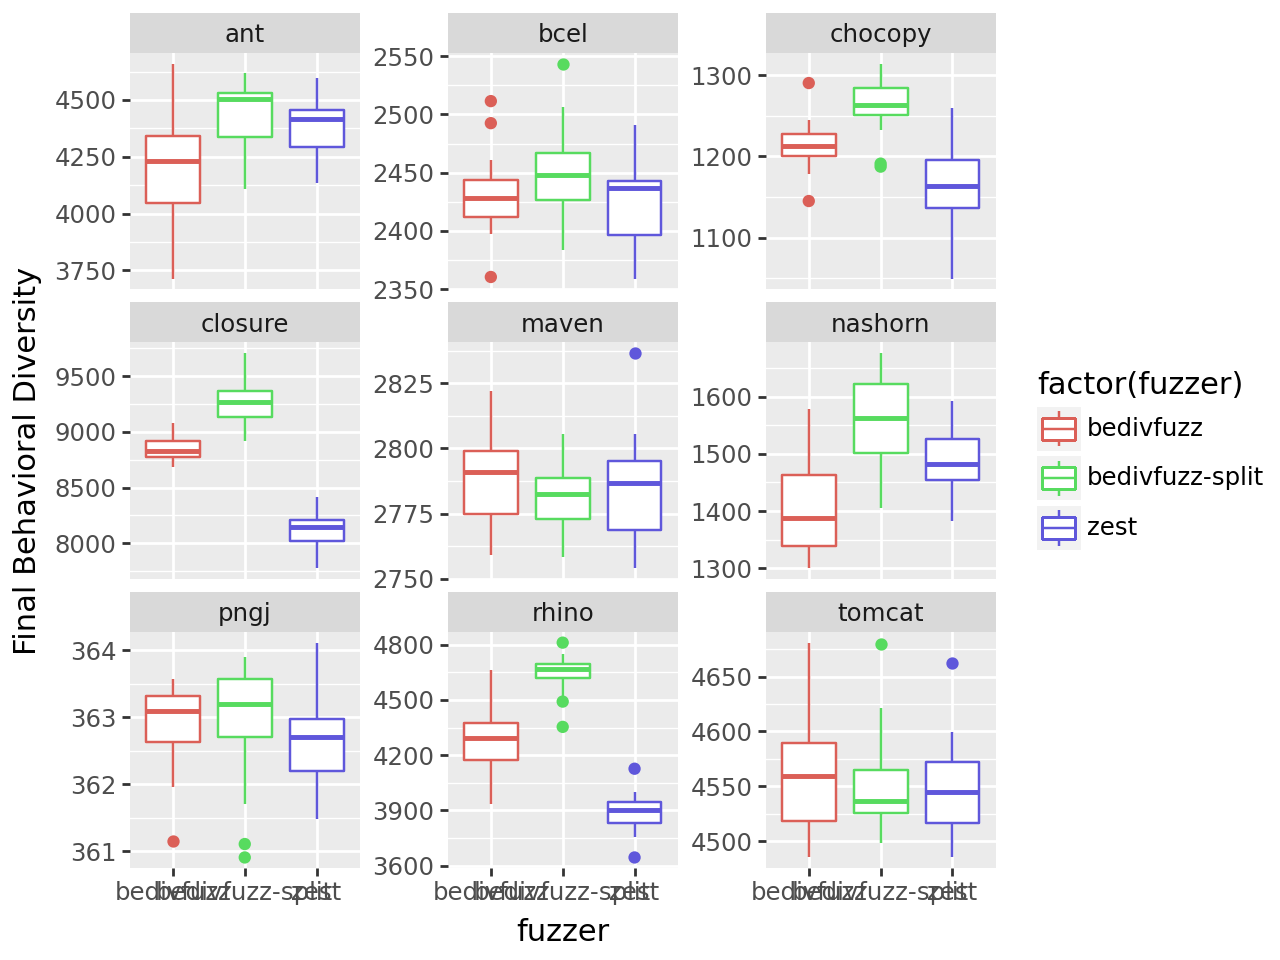

In [35]:
final_scores = trials.loc[trials['time'] == 180]

(ggplot(final_scores, aes("fuzzer", "b2", color="factor(fuzzer)"))
 + geom_boxplot()
 + facet_wrap("~subject", scales="free_y")
 + ylab("Final Behavioral Diversity")
)

In [61]:
trials.loc[trials['time'] == 180]

,fuzzer,subject,trial,time,valid_inputs,invalid_inputs,unique_paths,b0,b1,b2,validity_rate
3557,zest,ant,1,180,110363,273200,163383,6825.0,4676.33,4535.14,0.287731
3558,zest,ant,2,180,126456,265216,176134,6870.0,4665.15,4512.57,0.322862
3557,zest,ant,3,180,121684,250565,152393,6251.0,4668.65,4528.21,0.326889
3557,zest,ant,4,180,126351,254341,163233,6288.0,4674.42,4525.35,0.331898
3556,zest,ant,5,180,110876,253944,158623,6821.0,4674.28,4533.59,0.303920
...,...,...,...,...,...,...,...,...,...,...,...
3565,bedivfuzz-split,tomcat,16,180,232657,45146,230395,8322.0,5357.89,5154.30,0.837489
3562,bedivfuzz-split,tomcat,17,180,223014,30465,211875,8383.0,5280.32,5087.39,0.879813
3565,bedivfuzz-split,tomcat,18,180,229498,44821,223086,8373.0,5336.39,5130.83,0.836610
3565,bedivfuzz-split,tomcat,19,180,233119,26471,217277,8319.0,5251.71,5064.66,0.898028


In [24]:
import scipy.stats as stats

In [28]:
metric = 'b1'
alpha = 0.01
time = 180
for s in subjects:
    x = trials.query(f"fuzzer == 'zest' and subject == '{s}' and time == {time}")[metric].to_numpy()
    y = trials.query(f"fuzzer == 'bedivfuzz-split' and subject == '{s}' and time == {time}")[metric].to_numpy()

    if stats.mannwhitneyu(x, y, alternative='two-sided').pvalue < alpha:
        print(f"{s.ljust(10)}: {'zest' if np.mean(x) > np.mean(y) else 'bedivfuzz'}")
    else:
        print(f"{s.ljust(10)}: not significant")


ant       : not significant
bcel      : not significant
chocopy   : bedivfuzz
closure   : bedivfuzz
maven     : not significant
nashorn   : not significant
pngj      : not significant
rhino     : bedivfuzz
tomcat    : not significant


In [29]:
import math

crash_to_id = {}
def deduplicate_crash(exception_class, stack_trace):
    key = (exception_class, '-'.join(str(stack_trace).split('-')[:3]))
    if str(exception_class) == 'nan' or "OutOfMemoryError" in str(exception_class):
        return -1
    if key in crash_to_id.keys():
        return crash_to_id[key]
    else:
        crash_id = len(crash_to_id)
        crash_to_id[key] = crash_id
        return crash_id

In [30]:
def crash_trial_df(fuzzer: str, subject: str, trial: int):
    df = pd.read_csv(
        os.path.join(results_base_dir, fuzzer, subject, f'trial-1', 'failure_info.csv'),
        skipinitialspace=True
    )

    df['trial'] = trial
    df['fuzzer'] = fuzzer
    df['subject'] = subject
    df['crash_id'] = df.apply(lambda row: deduplicate_crash(row['exception_class'], row['top5_stack_trace']), axis=1)

    return df[['fuzzer', 'subject', 'trial', '# ttd', 'exception_class', 'crash_id']]

In [31]:
crash_dfs = []
for f, s, t in itertools.product(fuzzers, subjects, range(1, num_trials+1)):
    crash_dfs.append(crash_trial_df(fuzzer=f, subject=s, trial=t))
crash_trials = pd.concat(crash_dfs)

In [32]:
crash_trials = crash_trials.loc[crash_trials['crash_id'] != -1]

In [33]:
crash_trials.groupby(['subject', 'fuzzer'])['# ttd'].agg('median').round(0).astype(int)

subject  fuzzer         
bcel     bedivfuzz          2766590
         bedivfuzz-split    2717301
         zest               4362516
closure  bedivfuzz          6891526
         bedivfuzz-split    3325718
         zest               3825946
nashorn  bedivfuzz-split    4079040
rhino    bedivfuzz          5946736
         bedivfuzz-split    1030996
         zest               5662388
Name: # ttd, dtype: int64

In [35]:
crash_trials.groupby(['subject', 'fuzzer'])['crash_id'].agg('nunique')

subject  fuzzer   
bcel     zest         2
closure  bedivfuzz    2
         zest         5
rhino    bedivfuzz    3
         zest         2
Name: crash_id, dtype: int64

In [36]:
# Deduplicate bugs
crash_trials.groupby(['subject', 'fuzzer', 'trial', 'crash_id'])['# ttd'].agg('min')\
    .groupby(['subject', 'fuzzer', 'crash_id']).agg('mean').round(0).astype(int)

subject  fuzzer     crash_id
bcel     zest       0.0         1820713
                    1.0         2865616
closure  bedivfuzz  2.0         1610896
                    5.0         1449209
         zest       2.0         1029212
                    3.0         2743993
                    4.0         3285143
                    5.0         5459950
                    6.0         8506055
rhino    bedivfuzz  7.0          585640
                    8.0          299418
                    9.0          267042
         zest       7.0          129849
                    8.0          163704
Name: # ttd, dtype: int64

In [37]:
crash_to_id

{('class org.apache.bcel.verifier.exc.AssertionViolatedException',
  'org.apache.bcel.util.ClassPath.getClassFile(ClassPath.java:656)-org.apache.bcel.util.ClassPath.getInputStream(ClassPath.java:705)-org.apache.bcel.util.ClassPath.getInputStream(ClassPath.java:679)'): 0,
 ('class org.apache.bcel.verifier.exc.AssertionViolatedException',
  'java.base/jdk.internal.util.Preconditions.outOfBounds(Preconditions.java:64)-java.base/jdk.internal.util.Preconditions.outOfBoundsCheckIndex(Preconditions.java:70)-java.base/jdk.internal.util.Preconditions.checkIndex(Preconditions.java:248)'): 1,
 ('class java.lang.IllegalStateException',
  'com.google.javascript.jscomp.jarjar.com.google.common.base.Preconditions.checkState(Preconditions.java:590)-com.google.javascript.jscomp.LightweightMessageFormatter.padMultipleLines(LightweightMessageFormatter.java:237)-com.google.javascript.jscomp.LightweightMessageFormatter.getExcerptWithPosition(LightweightMessageFormatter.java:169)'): 2,
 ('class java.lang.Nu

In [38]:
crash_trials.groupby(['subject', 'fuzzer'])['crash_id'].unique()

subject  fuzzer   
bcel     zest                        [0.0, 1.0]
closure  bedivfuzz                   [5.0, 2.0]
         zest         [2.0, 3.0, 4.0, 5.0, 6.0]
rhino    bedivfuzz              [9.0, 8.0, 7.0]
         zest                        [7.0, 8.0]
Name: crash_id, dtype: object

In [39]:
crash_trials.groupby(['subject', 'fuzzer', 'trial', 'crash_id'])['# ttd'].agg('min')\
   .groupby(['subject', 'fuzzer', 'crash_id']).agg('count')

subject  fuzzer     crash_id
bcel     zest       0.0         10
                    1.0         10
closure  bedivfuzz  2.0         10
                    5.0         10
         zest       2.0         10
                    3.0         10
                    4.0         10
                    5.0         10
                    6.0         10
rhino    bedivfuzz  7.0         10
                    8.0         10
                    9.0         10
         zest       7.0         10
                    8.0         10
Name: # ttd, dtype: int64